# Task 2: Hyperelasticity



In [2]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib

# %% Own modules
import models as lm
importlib.reload(lm)

<module 'models' from 'f:\\CPShub\\Tutorial\\Task2_Group Xin and Huasen\\train\\models.py'>

### Data import

In [3]:
import numpy as np


data_biaxial = np.loadtxt('../calibration/biaxial.txt')
data_pure_shear = np.loadtxt('../calibration/pure_shear.txt')
data_uniaxial = np.loadtxt('../calibration/uniaxial.txt')


def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    W = data[:, 18] 
    return F, P, W

# 分别处理三种加载路径的数据
F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_pure_shear, P_pure_shear, W_pure_shear = process_data(data_pure_shear)
F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)

# 检查数据
print("Biaxial F:", F_biaxial.shape)
print("Biaxial P:", P_biaxial.shape)
print("Biaxial W:", W_biaxial.shape)

print("Pure Shear F:", F_pure_shear.shape)
print("Pure Shear P:", P_pure_shear.shape)
print("Pure Shear W:", W_pure_shear.shape)

print("Uniaxial F:", F_uniaxial.shape)
print("Uniaxial P:", P_uniaxial.shape)
print("Uniaxial W:", W_uniaxial.shape)


Biaxial F: (199, 3, 3)
Biaxial P: (199, 3, 3)
Biaxial W: (199,)
Pure Shear F: (250, 3, 3)
Pure Shear P: (250, 3, 3)
Pure Shear W: (250,)
Uniaxial F: (199, 3, 3)
Uniaxial P: (199, 3, 3)
Uniaxial W: (199,)


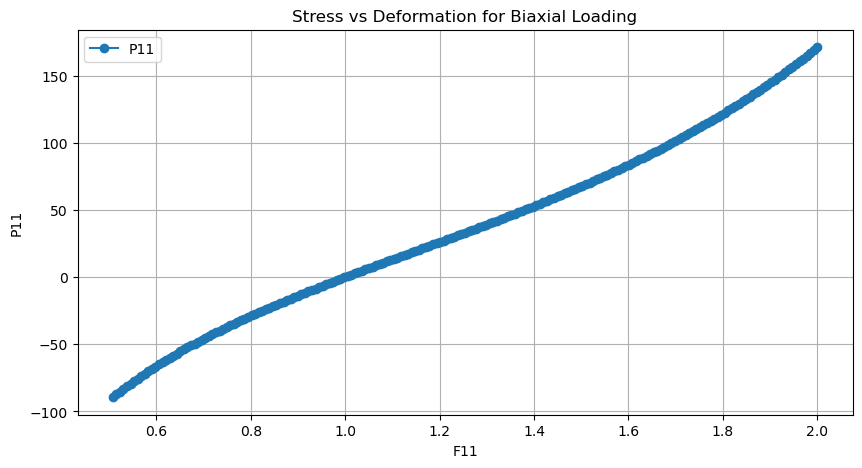

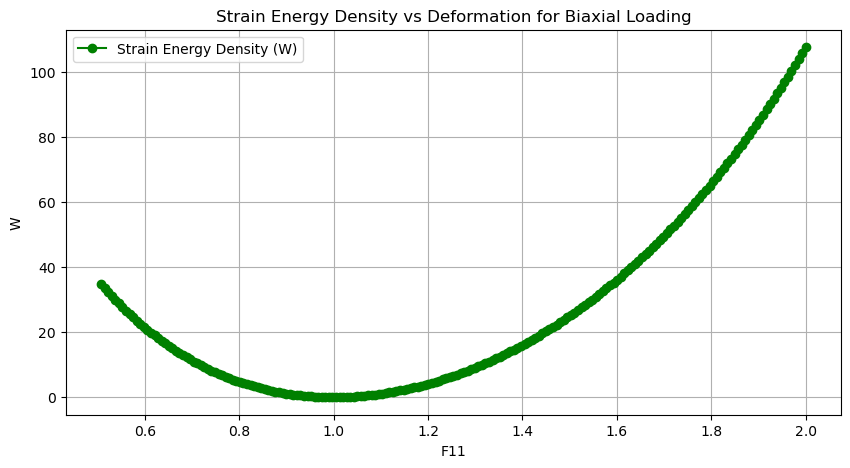

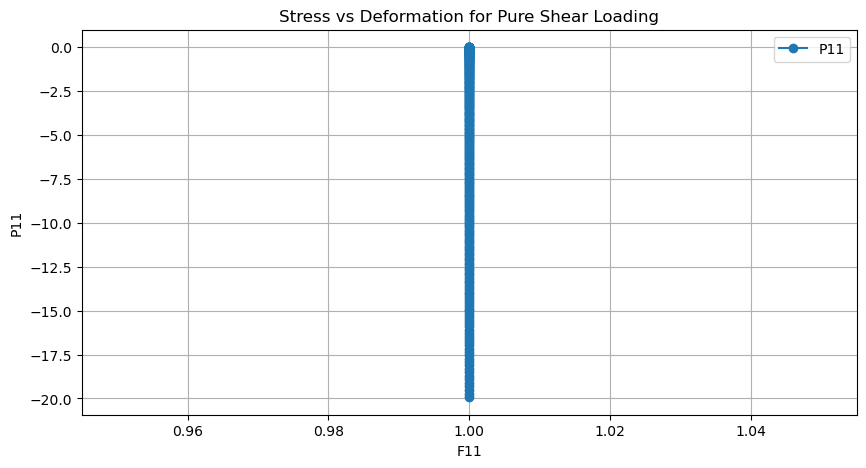

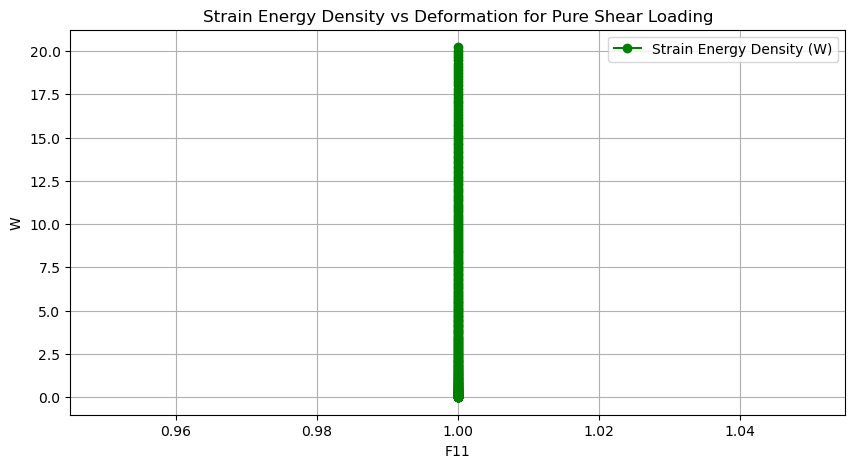

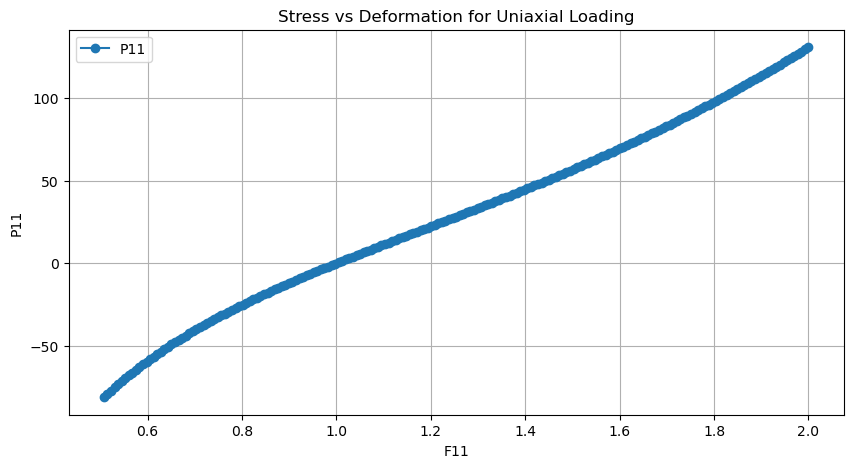

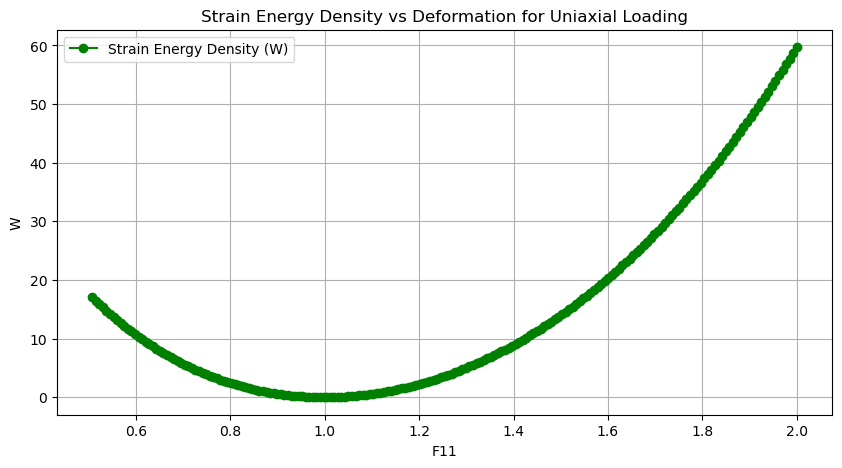

In [4]:
import matplotlib.pyplot as plt

# 可视化函数
def plot_stress_vs_deformation(F, P, W, title):
    # 假设我们主要关注 F11 和 P11 的关系
    F11 = F[:, 0, 0]  # 提取 F11 分量
    P11 = P[:, 0, 0]  # 提取 P11 分量

    # 绘制 P11 与 F11 的关系
    plt.figure(figsize=(10, 5))
    plt.plot(F11, P11, label="P11", marker="o", linestyle="-")
    plt.xlabel("F11")
    plt.ylabel("P11")
    plt.title(f"Stress vs Deformation for {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 绘制 W 与 F11 的关系
    plt.figure(figsize=(10, 5))
    plt.plot(F11, W, label="Strain Energy Density (W)", marker="o", linestyle="-", color="green")
    plt.xlabel("F11")
    plt.ylabel("W")
    plt.title(f"Strain Energy Density vs Deformation for {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

# 分别绘制不同加载路径的结果
plot_stress_vs_deformation(F_biaxial, P_biaxial, W_biaxial, title="Biaxial Loading")
plot_stress_vs_deformation(F_pure_shear, P_pure_shear, W_pure_shear, title="Pure Shear Loading")
plot_stress_vs_deformation(F_uniaxial, P_uniaxial, W_uniaxial, title="Uniaxial Loading")


In [91]:
import numpy as np

import tensorflow as tf

def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    # F shape is (batch_size, 3, 3)
    batch_size = tf.shape(F)[0]
    
    # 计算右 Cauchy-Green 张量 C = F^T * F
    # Using einsum for batch matrix multiplication
    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = tf.linalg.trace(C)  # shape: (batch_size,)
    
    # For I2, compute trace(C@C) with batch operation
    C_square = tf.einsum('bij,bjk->bik', C, C)
    I2 = 0.5 * (I1**2 - tf.linalg.trace(C_square))  # shape: (batch_size,)
    
    # Compute determinant for each matrix in the batch
    J = tf.linalg.det(F)  # shape: (batch_size,)
    
    # 定义结构张量 Gti
    Gti = tf.constant([
        [4, 0, 0],
        [0, 0.5, 0],
        [0, 0, 0.5]
    ], dtype=tf.float32)
    
    # 扩展 Gti 到批量维度
    Gti = tf.tile(Gti[None, :, :], [batch_size, 1, 1])
    
    # 计算不变量 I4
    I4 = tf.linalg.trace(tf.einsum('bij,bjk->bik', C, Gti))  # shape: (batch_size,)
    
    # 计算 C 的余因子（Cofactor）
    # First compute inverse of C for each matrix in batch
    I3 = tf.linalg.det(C)

# 使用 I3 和 C 的逆计算 Cofactor 矩阵
    Cof_C = I3[:, None, None] * tf.linalg.inv(C)

    # 计算不变量 I5
    I5 = tf.linalg.trace(tf.einsum('bij,bjk->bik', Cof_C, Gti))  # shape: (batch_size,)
    
    return I1, J, I4, I5

In [88]:
#@tf.function
def neo_hookean_potential(I1, J, I4, I5):
    # 计算应变能密度 W
    W = 8 * I1 + 10 * (J ** 2) - 56 * tf.math.log(J) + 0.2 * (I4 ** 2 + I5 ** 2) - 44
    return W


In [89]:
def process_invariants(data):

    I_1 = data[:, 0]
    J = data[:, 1]
    I_4 = data[:, 2]
    I_5 = data[:, 3]
    return I_1, J, I_4, I_5

In [92]:
I1_biaxial_pred, J_biaxial_pred, I4_biaxial_pred, I5_biaxial_pred = compute_invariants(F_biaxial) 
def check_invariants(pred, data):
    return np.allclose(pred, data, atol=1e-2)
data_biaxial_I = np.loadtxt('../invariants/I_biaxial.txt')
I1_data_biaxial,J_data_biaxial,I4_data_biaxial,I5_data_biaxial = process_invariants(data_biaxial_I)
print("Biaxial I1 Check:", check_invariants(I1_biaxial_pred, I1_data_biaxial))
print("Biaxial J Check:", check_invariants(J_biaxial_pred, J_data_biaxial))
print("Biaxial I4 Check:", check_invariants(I4_biaxial_pred, I4_data_biaxial))
print("Biaxial I5 Check:", check_invariants(I5_biaxial_pred, I5_data_biaxial))

Biaxial I1 Check: True
Biaxial J Check: True
Biaxial I4 Check: True
Biaxial I5 Check: True


In [ ]:
# 计算应力张量 P
def compute_stress_tensor(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(F)
        
        # 计算不变量 I1, J, I4 和 I5
        I1, J, I4, I5 = compute_invariants(F)
        
        # 计算应变能函数 W
        W = neo_hookean_potential(I1, J, I4, I5)
    
    # 使用自动微分计算应力张量 P = dW/dF
    #print("W shape:", W.shape)
    P = tape.gradient(W, F)
    return P

In [96]:
P_biaxial_compute = compute_stress_tensor(F_biaxial)

W shape: (199,)


In [97]:
print("Biaxial P shape:", P_biaxial_compute.shape)

Biaxial P shape: (199, 3, 3)


In [100]:
print("Biaxial I1 Check:", check_invariants(P_biaxial_compute, P_biaxial))

Biaxial I1 Check: True


In [11]:
import numpy as np

F_train = np.concatenate([F_biaxial.reshape(-1, 9), F_pure_shear.reshape(-1, 9), F_uniaxial.reshape(-1, 9)], axis=0)
P_train = np.concatenate([P_biaxial.reshape(-1, 9), P_pure_shear.reshape(-1, 9), P_uniaxial.reshape(-1, 9)], axis=0)




data_biaxial_test = np.loadtxt('../test/biax_test.txt')
data_mixed_test = np.loadtxt('../test/mixed_test.txt')




F_mixed_test, P_mixed_test, W_mixed_test = process_data(data_mixed_test)
F_biaxial_test, P_biaxial_test, W_biaxial_test = process_data(data_biaxial_test)


F_test = np.concatenate([F_mixed_test.reshape(-1, 9), F_biaxial_test.reshape(-1, 9)], axis=0)
P_test = np.concatenate([P_mixed_test.reshape(-1, 9), P_biaxial_test.reshape(-1, 9)], axis=0)


In [12]:
print(F_train.shape, P_train.shape)

(648, 9) (648, 9)


### Load model

In [13]:
model1 = lm.main()


model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 private_c_to_p (_C_to_P)    (None, 9)                 93        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
21/21 [==============================] - 1s 11ms/step - loss: 448.4934 - val_loss: 399.8746
Epoch 2/2500
21/21 [==============================] - 0s 4ms/step - loss: 447.6852 - val_loss: 399.1111
Epoch 3/2500
21/21 [==============================] - 0s 4ms/step - loss: 446.9317 - val_loss: 398.4118
Epoch 4/2500
21/21 [==============================] - 0s 4ms/step - loss: 446.2487 - val_loss: 397.7311
Epoch 5/2500
21/21 [==============================] - 0s 4ms/step - loss: 445.5937 - val_loss: 397.2358
Epoch 6/2500
21/21 [==============================] - 0s 4ms/step - loss: 444.9526 - val_loss: 396.6419
Epoch 7/2500
21/21 [==============================] - 0s 4ms/step - loss: 444.3025 - val_loss: 396.0776
Epoch 8/2500
21/21 [==============================] - 0s 4ms/step - loss: 443.6205 - val_loss: 395.4996
Epoch 9/2500
21/21 [==============================] - 0s 4ms/step - loss: 442.9196 - val_loss: 394.8850
Epoch 10/2500
21/21 [==============================] - 0s 5ms/s

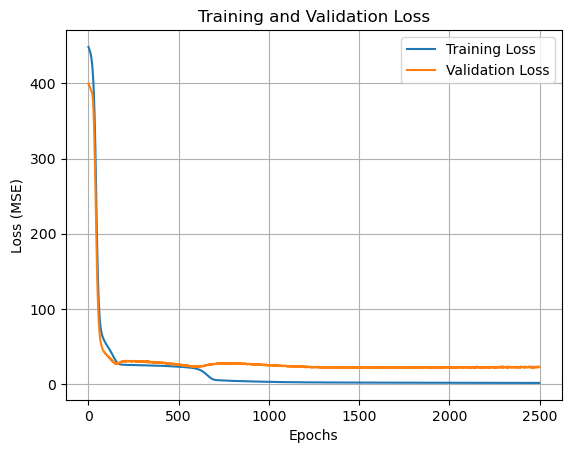

In [14]:
# 训练模型
def convert_F_to_C(F_data):
    # 将 F_data 重塑为 (N, 3, 3) 形状
    F_data = F_data.reshape(-1, 3, 3)
    # 对每个样本计算 C = F^T * F
    C_data = np.einsum('...ji,...jk->...ik', F_data, F_data)
    # 提取对称矩阵 C 的六个独立分量
    C_data_6 = np.stack([C_data[:, 0, 0],  # c11
                         C_data[:, 1, 1],  # c22
                         C_data[:, 2, 2],  # c33
                         C_data[:, 0, 1],  # c12
                         C_data[:, 0, 2],  # c13
                         C_data[:, 1, 2]], axis=-1)  # c23
    return C_data_6

# 转换训练和测试数据
C_train = convert_F_to_C(F_train)
C_test = convert_F_to_C(F_test)


# 模型训练
history = model1.fit(C_train, P_train, epochs=2500, validation_data=(C_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


7/7 [==============================] - 0s 2ms/step


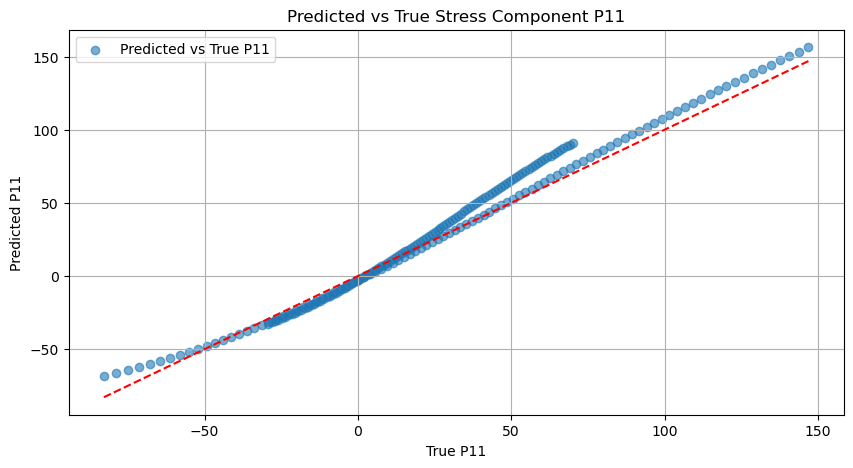

In [15]:
# 预测测试集上的应力分量

P_pred = model1.predict(C_test)

# 可视化真实值与预测值的对比
plt.figure(figsize=(10, 5))
plt.scatter(P_test[:, 0], P_pred[:, 0], label="Predicted vs True P11", alpha=0.6)
plt.xlabel("True P11")
plt.ylabel("Predicted P11")
plt.title("Predicted vs True Stress Component P11")
plt.plot([min(P_test[:, 0]), max(P_test[:, 0])], [min(P_test[:, 0]), max(P_test[:, 0])], color='red', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


4/4 [==============================] - 0s 2ms/step


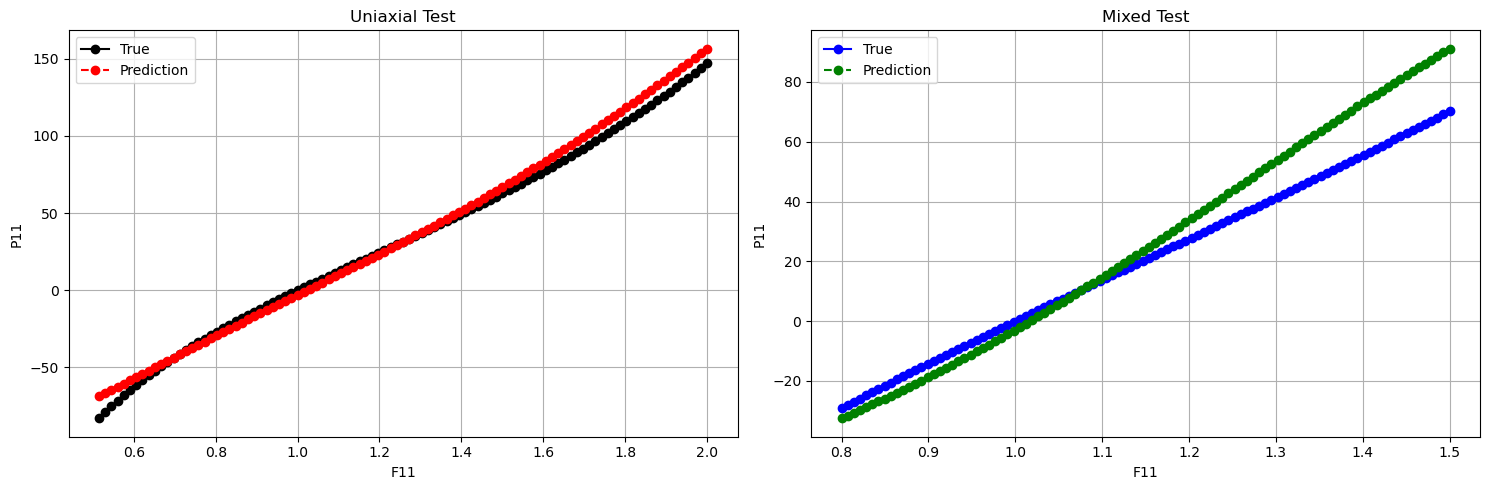

In [16]:
import matplotlib.pyplot as plt

C_biaxial_test = convert_F_to_C(F_biaxial_test.reshape(-1, 9))
C_mixed_test = convert_F_to_C(F_mixed_test.reshape(-1, 9))

P_biaxial_test_pred = model1.predict(C_biaxial_test)

P_mixed_test_pred = model1.predict(C_mixed_test)

def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0]


    # 创建一个包含三个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test")
    ax2.legend()
    ax2.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)


7/7 [==============================] - 0s 2ms/step


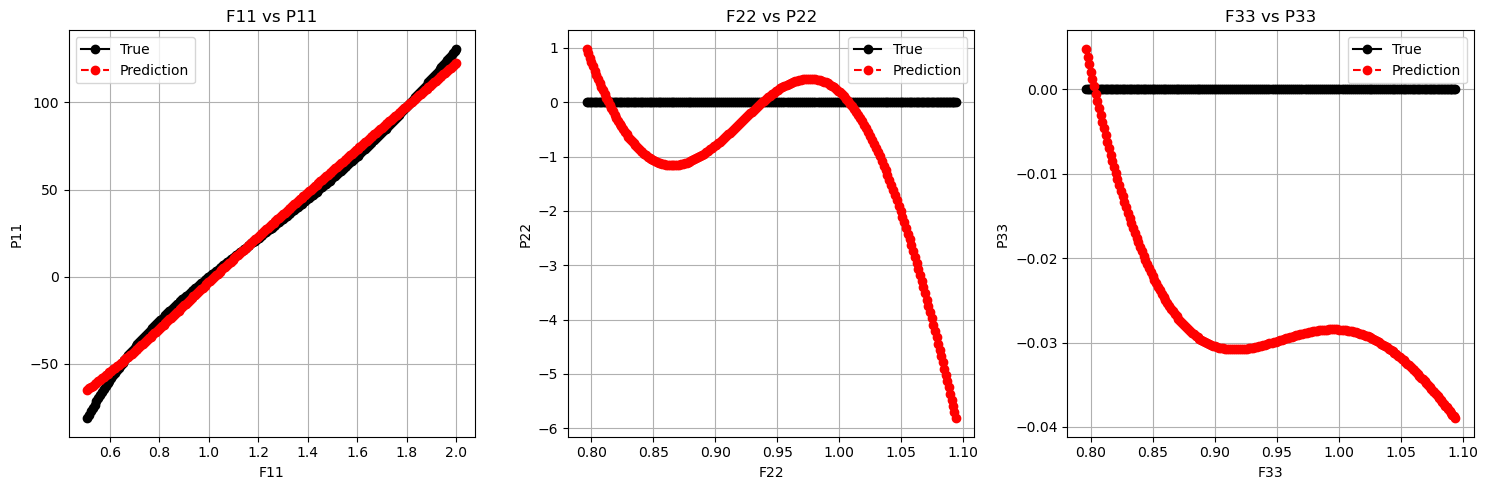

In [17]:
C_uniaxial = convert_F_to_C(F_uniaxial.reshape(-1, 9))
P_uniaxial_pred = model1.predict(C_uniaxial).reshape(-1, 3, 3)
import matplotlib.pyplot as plt
import numpy as np

def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    # 提取 F 和 P 的不同分量
    F11 = F_uniaxial[:, 0, 0]  # 第一列
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] # 第三列

    P11 = P_uniaxial[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_uniaxial[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_uniaxial[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_uniaxial_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_uniaxial_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_uniaxial_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)


### Loss weighting strategy

In [34]:
model2 = lm.main()


model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6)]               0         
                                                                 
 private_c_to_p_2 (_C_to_P)  (None, 9)                 93        
                                                                 
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


In [35]:
print(P_biaxial.shape)

(199, 3, 3)


In [71]:
import numpy as np



def calculate_path_weight(P_values):
   
    norm = np.linalg.norm(P_values,'fro', axis=(1, 2)).mean()
    return 1 / norm  


weight_biaxial = calculate_path_weight(P_biaxial)
weight_pure_shear = calculate_path_weight(P_pure_shear)
weight_uniaxial = calculate_path_weight(P_uniaxial)


sample_weights = np.concatenate([
    np.full(P_biaxial.shape[0], weight_biaxial),      
    np.full(P_pure_shear.shape[0], weight_pure_shear), 
    np.full(P_uniaxial.shape[0], weight_uniaxial)     
])

#sample_weights /= np.sum(sample_weights)


print("Sample weights:", sample_weights)
print("Sum of sample weights:", np.sum(sample_weights))

Sample weights: [0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909 0.01400909
 0.01400909 0.01400909 0.01400909 0.01400909 0

In [72]:
print("weight_biaxial:", weight_biaxial)
print("weight_pure_shear:", weight_pure_shear)
print("weight_uniaxial:", weight_uniaxial)

weight_biaxial: 0.014009094220516313
weight_pure_shear: 0.03335082320164705
weight_uniaxial: 0.019330317859574873


In [45]:
P_list = [
    tf.convert_to_tensor(P_uniaxial, dtype=tf.float32),
    tf.convert_to_tensor(P_biaxial, dtype=tf.float32),
    tf.convert_to_tensor(P_pure_shear, dtype=tf.float32)
]


In [ ]:
def calc_weights(P_list):
    # 计算每个路径的范数均值并取倒数作为权重
    norm_P_uniax = tf.norm(P_list[0], ord='fro', axis=[1, 2])
    weights_uniax_mean = tf.math.reduce_mean(norm_P_uniax)
    weights_uniax = 1 / weights_uniax_mean
    weights_uniax_norm = weights_uniax

    norm_P_biax = tf.norm(P_list[1], ord='fro', axis=[1, 2])
    weights_biax_mean = tf.math.reduce_mean(norm_P_biax)
    weights_biax = 1 / weights_biax_mean
    weights_biax_norm = weights_biax

    norm_P_shear = tf.norm(P_list[2], ord='fro', axis=[1, 2])
    weights_shear_mean = tf.math.reduce_mean(norm_P_shear)
    weights_shear = 1 / weights_shear_mean
    weights_shear_norm = weights_shear

    # 创建对应长度的权重张量并应用归一化因子
    w_uniax = tf.ones([199,]) * weights_uniax_norm
    w_biax = tf.ones([199,]) * weights_biax_norm
    w_shear = tf.ones([250,]) * weights_shear_norm

    # 拼接所有权重
    
    weights = tf.concat([w_uniax, w_biax, w_shear], axis=0)

    return weights

weights = calc_weights(P_list)

In [56]:
first_199 = tf.reduce_sum(weights[:199])
middle_199 = tf.reduce_sum(weights[199:398])  # from index 199 to 398
last_250 = tf.reduce_sum(weights[398:])  # from index 398 to end

print("Sum of first 199 weights (uniaxial):", first_199.numpy())
print("Sum of middle 199 weights (biaxial):", middle_199.numpy())
print("Sum of last 250 weights (shear):", last_250.numpy())

print("each of first 199 weights (uniaxial):", first_199.numpy()/199)
print("each of middle 199 weights (biaxial):", middle_199.numpy()/199)
print("each of last 250 weights (shear):", last_250.numpy()/250)

Sum of first 199 weights (uniaxial): 3.8467338
Sum of middle 199 weights (biaxial): 2.7878098
Sum of last 250 weights (shear): 8.337706
each of first 199 weights (uniaxial): 0.019330320645816364
each of middle 199 weights (biaxial): 0.014009094717514575
each of last 250 weights (shear): 0.03335082244873047


In [44]:
sum_first_216 = np.sum(sample_weights[:199])
sum_middle_216 = np.sum(sample_weights[199:449])
sum_last_216 = np.sum(sample_weights[449:])

print("first:", sum_first_216)
print("seconde:", sum_middle_216)
print("thrid:", sum_last_216)


first: 0.18619846532825446
seconde: 0.5568773207929458
thrid: 0.25692421387879977


In [43]:
print(weight_biaxial)

0.014009094220516313


In [38]:
print(sample_weights.shape)

(648,)


In [39]:
C_train = convert_F_to_C(F_train)
C_test = convert_F_to_C(F_test)

Epoch 1/2500
21/21 [==============================] - 1s 10ms/step - loss: 0.5546 - val_loss: 415.1752
Epoch 2/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5505 - val_loss: 411.8889
Epoch 3/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5470 - val_loss: 408.9743
Epoch 4/2500
21/21 [==============================] - 0s 5ms/step - loss: 0.5438 - val_loss: 406.1872
Epoch 5/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5409 - val_loss: 403.9354
Epoch 6/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5382 - val_loss: 401.4744
Epoch 7/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5355 - val_loss: 399.1891
Epoch 8/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5328 - val_loss: 396.7964
Epoch 9/2500
21/21 [==============================] - 0s 6ms/step - loss: 0.5299 - val_loss: 394.3902
Epoch 10/2500
21/21 [==============================] - 0s 5ms/step - loss: 0.5269

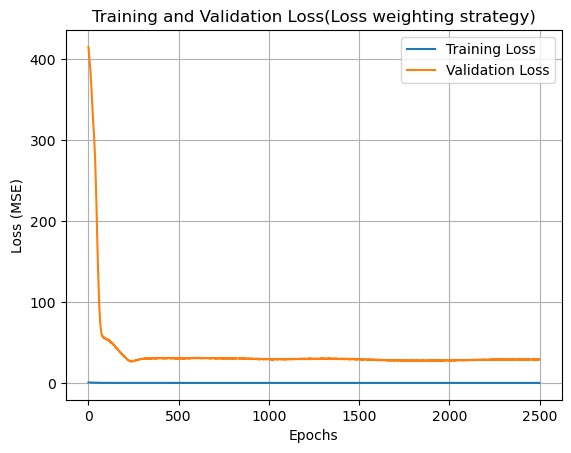

In [40]:
# 训练模型
history = model2.fit(C_train, P_train, epochs=2500, sample_weight=sample_weights, validation_data=(C_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss(Loss weighting strategy)")
plt.grid(True)
plt.show()

7/7 [==============================] - 0s 2ms/step


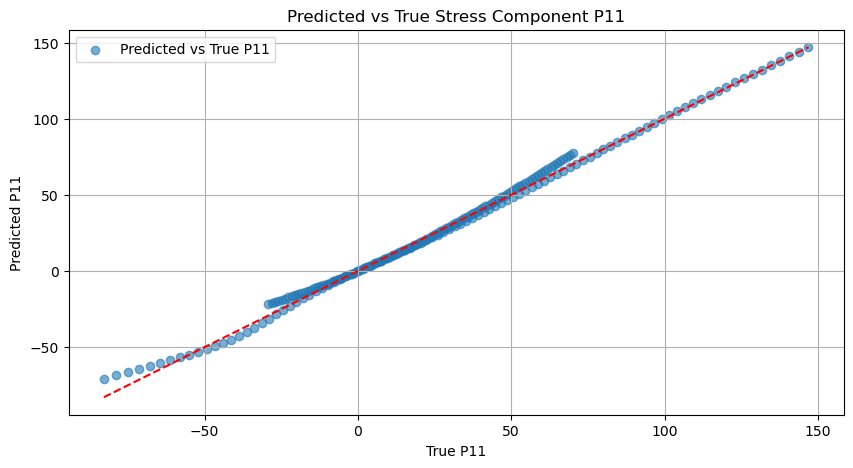

In [23]:
# 预测测试集上的应力分量
P_pred = model2.predict(C_test)

# 可视化真实值与预测值的对比
plt.figure(figsize=(10, 5))
plt.scatter(P_test[:, 0], P_pred[:, 0], label="Predicted vs True P11", alpha=0.6)
plt.xlabel("True P11")
plt.ylabel("Predicted P11")
plt.title("Predicted vs True Stress Component P11")
plt.plot([min(P_test[:, 0]), max(P_test[:, 0])], [min(P_test[:, 0]), max(P_test[:, 0])], color='red', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


4/4 [==============================] - 0s 2ms/step


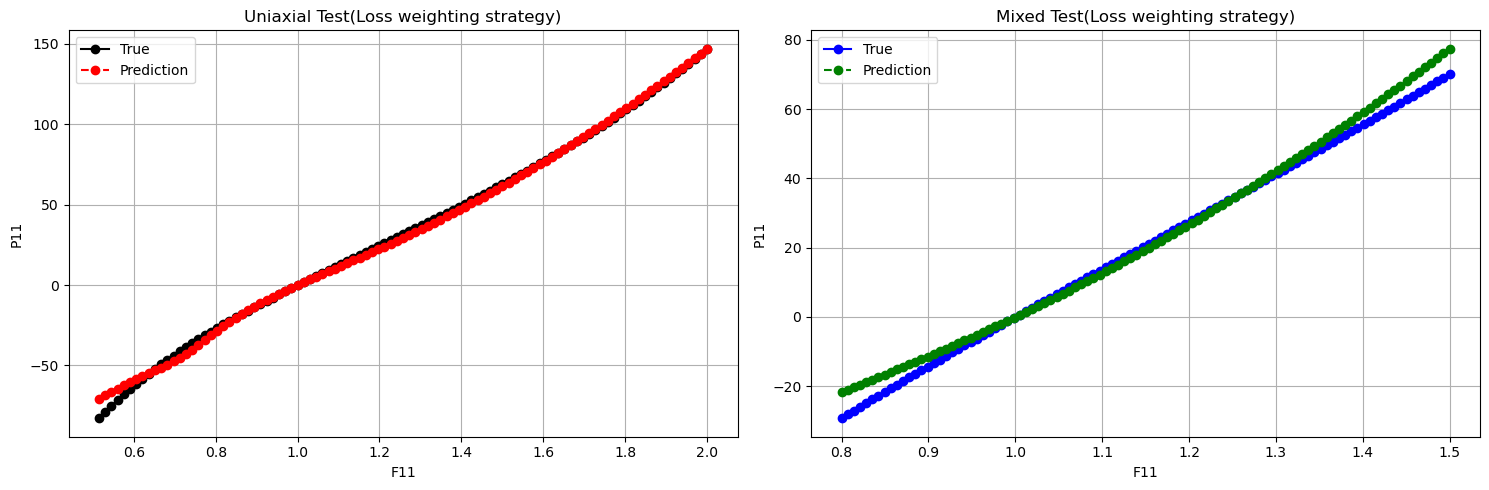

In [24]:
import matplotlib.pyplot as plt

C_biaxial_test = convert_F_to_C(F_biaxial_test.reshape(-1, 9))
C_mixed_test = convert_F_to_C(F_mixed_test.reshape(-1, 9))

P_biaxial_test_pred = model2.predict(C_biaxial_test)

P_mixed_test_pred = model2.predict(C_mixed_test)

def plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                                 F_mixed_test, P_mixed_test, P_mixed_test_pred):

    F11_biaxial_test = F_biaxial_test[:, 0, 0]
    P11_biaxial_test = P_biaxial_test[:, 0, 0]
    P11_biaxial_test_pred = P_biaxial_test_pred[:, 0]

    F11_mixed_test = F_mixed_test[:, 0, 0]
    P11_mixed_test = P_mixed_test[:, 0, 0]
    P11_mixed_test_pred = P_mixed_test_pred[:, 0]


    # 创建一个包含三个子图的图形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial_test, P11_biaxial_test, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial_test, P11_biaxial_test_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Uniaxial Test(Loss weighting strategy)")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_mixed_test, P11_mixed_test, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_mixed_test, P11_mixed_test_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Mixed Test(Loss weighting strategy)")
    ax2.legend()
    ax2.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial_test, P_biaxial_test, P_biaxial_test_pred, 
                             F_mixed_test, P_mixed_test, P_mixed_test_pred)


7/7 [==============================] - 0s 1ms/step


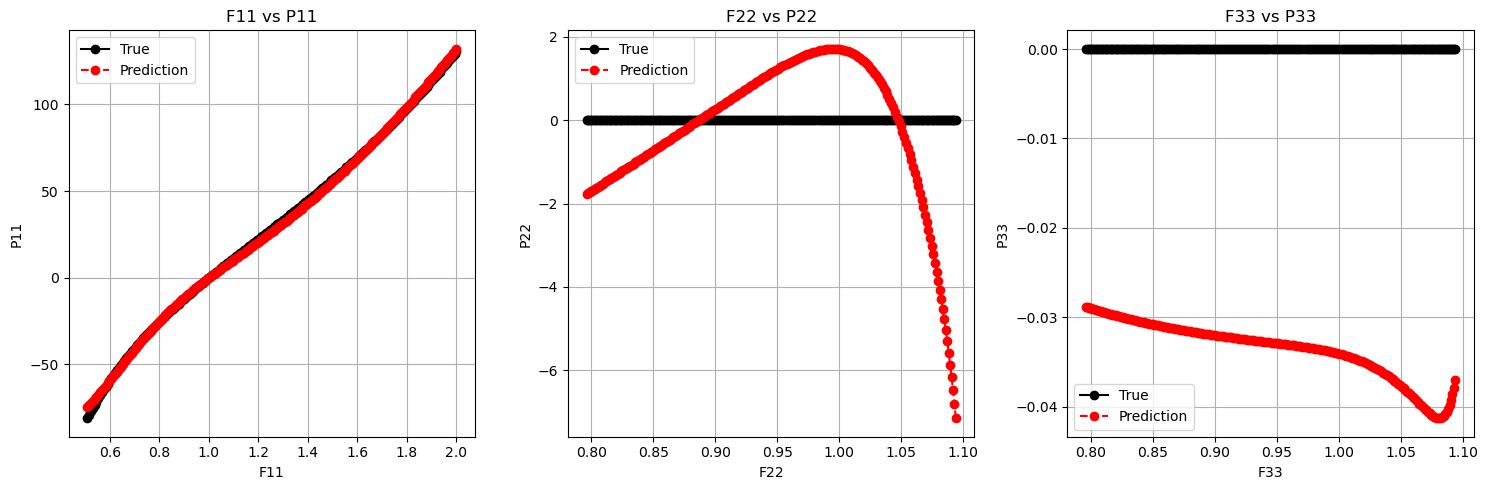

In [25]:
C_uniaxial = convert_F_to_C(F_uniaxial.reshape(-1, 9))
P_uniaxial_pred = model2.predict(C_uniaxial).reshape(-1, 3, 3)
import matplotlib.pyplot as plt
import numpy as np

def plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred):
    # 提取 F 和 P 的不同分量
    F11 = F_uniaxial[:, 0, 0]  # 第一列
    F22 = F_uniaxial[:, 1, 1]  
    F33 = F_uniaxial[:, 2, 2] # 第三列

    P11 = P_uniaxial[:, 0, 0]  # 原始 P 的 11 元素
    P22 = P_uniaxial[:, 1, 1]  # 原始 P 的 22 元素
    P33 = P_uniaxial[:, 2, 2]  # 原始 P 的 33 元素

    P11_pred = P_uniaxial_pred[:, 0, 0]  # 预测 P 的 11 元素
    P22_pred = P_uniaxial_pred[:, 1, 1]  # 预测 P 的 22 元素
    P33_pred = P_uniaxial_pred[:, 2, 2]  # 预测 P 的 33 元素

    # 创建绘图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用函数
plot_all_stress_vs_deformation(F_uniaxial, P_uniaxial, P_uniaxial_pred)


In [70]:
# Let's say we have a tensor/array P with shape (-1, 3, 3)
# Example:
P = [[[1, 2, 3],    # First 3x3 matrix
      [4, 5, 6],
      [7, 8, 9]],
     
     [[2, 3, 4],    # Second 3x3 matrix
      [5, 6, 7],
      [8, 9, 10]]]

# Step 1: Calculate Frobenius norm for each 3x3 matrix
# Frobenius norm = sqrt(sum of squares of all elements in matrix)

# For first matrix:
# sqrt(1² + 2² + 3² + 4² + 5² + 6² + 7² + 8² + 9²) ≈ 16.88

# For second matrix:
# sqrt(2² + 3² + 4² + 5² + 6² + 7² + 8² + 9² + 10²) ≈ 19.62

# In code:
# NumPy version:
norms1 = np.linalg.norm(P_uniaxial, axis=(1, 2)).mean()
norms1 = 1 / norms1  
#norms1 = np.mean(norms1)
# Result: [16.88, 19.62]

P_values = tf.convert_to_tensor(P_uniaxial, dtype=tf.float32)
# TensorFlow version:
norms2 = tf.norm(P_values, ord='fro', axis=[1, 2])
norms2 = tf.math.reduce_mean(norms2)
norms2 = 1 / norms2
norms2 = tf.ones([199,]) * norms2
# Result: [16.88, 19.62]
print("NumPy norms:", norms1)
print("TensorFlow norms:", norms2.numpy()) 

NumPy norms: 0.019330317859574873
TensorFlow norms: [0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032 0.01933032
 0.0193303